# Sea Ice Extent and Area computation

**Author**: T. Lavergne (METNO)

Demonstration notebook [DD-JNB] prepared for TC#2 (Technical Check Point #2) in the CIMR L2PAD project. The notebook demonstrates computing sea-ice extent and area from daily complete (Level-3/4) maps of SIC.

Although sea-ice extent is not a Level-2 product per se, and will thus not be derived in the L2 Ground Processing Prototype (GPP) developed in CIMR L2PAD, its algorithm is documented in the SIC ATBD.

In this notebook, we demonstrate computing sea-ice extent (and sea-ice area) from a daily SIC files from the EUMETSAT Ocean and Sea Ice Satellite Application Facility (OSI SAF). We access the SIC files directly online, via the OpenDAP protocol.

In [47]:
import xarray as xr

import numpy as np
from datetime import date

from matplotlib import pylab as plt

In [51]:
dt = date(2025,3,15)

## Access and load SIC data

In [52]:
osisaf_fn = dict()
osisaf_fn['nh'] = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/{d:%Y/%m}/ice_conc_nh_ease2-250_icdr-v3p0_{d:%Y%m%d}1200.nc'.format(d=dt)
osisaf_fn['sh'] = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/{d:%Y/%m}/ice_conc_sh_ease2-250_icdr-v3p0_{d:%Y%m%d}1200.nc'.format(d=dt)

In [53]:
osisaf_ds = dict()
for a in osisaf_fn.keys():
    osisaf_ds[a] = xr.open_dataset(osisaf_fn[a])

## Visualize SIC maps 

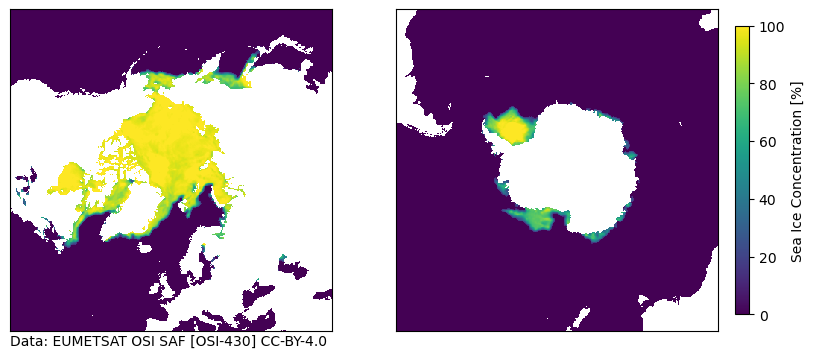

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5), sharex=True, sharey=True)
ax[0].imshow(osisaf_ds['nh']['ice_conc'][0], vmin=0, vmax=100, interpolation='none')
c = ax[1].imshow(osisaf_ds['sh']['ice_conc'][0], vmin=0, vmax=100, interpolation='none')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.colorbar(c, ax=ax, shrink=0.75, pad=0.02).set_label('Sea Ice Concentration [%]')
ax[0].text(0., -0.01, 'Data: EUMETSAT OSI SAF [OSI-430] CC-BY-4.0', transform=ax[0].transAxes, va='top')
plt.show()

## Compute Sea Ice Extent and Area

The OSI SAF SIC product is on an Equal Area Scalabel Earth (EASE2) grid with 25 km spacing. Each grid cell thus amounts for 25 x 25 km^2 area.

The OSI SAF SIC also include values over Lakes. We use their status flag to mask lake ice before computing sea-ice extent and area.

We use a threshold of 15% for computing sea-ice extent, but no threshold (0%) for sea-ice area.

In [65]:
cell_area = 25. * 25.

In [68]:
sie = dict()
sia = dict()
for a in osisaf_fn.keys():
    sic = osisaf_ds[a]['ice_conc'][0].values
    flg = osisaf_ds[a]['status_flag'][0].values.astype('int16')
    sic[flg&2==2] = np.nan
    sie[a] = (sic >= 15).astype('int').sum() * cell_area
    sia[a] = np.nansum(sic/100.) * cell_area

In [69]:
print("Results for {}".format(dt))
for a in osisaf_fn.keys():
    print(a.upper())
    print('\tSIE is {:.1f} km^2'.format(sie[a]))
    print('\tSIA is {:.1f} km^2'.format(sia[a]))

Results for 2025-03-15
NH
	SIE is 14262500.0 km^2
	SIA is 12877585.8 km^2
SH
	SIE is 3311250.0 km^2
	SIA is 2123888.0 km^2
